In [23]:
import sys
sys.path.insert(0, "..")
from pathlib import Path
import re
import json
from pprint import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.collections as mc
import matplotlib.cm as cm
from packaging import version

BENCHMARK = 'pmem2bench'

def pretty_fmt(num, suffix="B"):
    for unit in ["", "K", "M", "G", "T", "P", "E", "Z"]:
        if abs(num) < 1024.0:
            return f"{num:3.0f}{unit}{suffix}"
        num /= 1024.0
    return f"{num:.1f}Y{suffix}"

FIG_DIR = Path(f'../fig/{BENCHMARK}').resolve()
FIG_DIR.mkdir(parents=True, exist_ok=True)
def save(fig, name):
    for ext in ('png', 'eps'):
        fig.savefig(FIG_DIR / f'{name}.{ext}', bbox_inches = 'tight')
    # pass 

In [24]:
!pwd

/work/0/NBB/hiraga/work/pmembench/eval/plot


In [25]:
RAW_BASEDIR=Path("../raw/")

job_group = (
    ("pegasus/pmem2bench/2023.06.22-18.16.11", {"platform": "pegasus"}),
    ("pegasus/pmem2bench/2023.06.22-19.16.25", {"platform": "pegasus"}),
    ("pegasus/pmem2bench/2023.06.23-12.22.20", {"platform": "pegasus"}),
    ("cygnus/pmem2bench/2023.06.23-14.34.22", {"platform": "cygnus"}),
    ("chris90/pmem2bench/2023.06.23-18.02.15", {"platform": "chris90"}),
)

def parse_result(json_file: Path):
    with json_file.open() as f:
        return json.load(f)


re_iter = re.compile(r"_([0-9]+)\.json")
def parse_iter_from_filename(json_file: Path):
    m = re_iter.search(json_file.name)
    if m:
        return int(m.groups()[0])
    else:
        raise Exception("parse error: iteration")

failed_job_count = 0
job_params = []
job_results = []
for job_dir, meta_overwrite in job_group:
    job_dir = RAW_BASEDIR / job_dir
    for job_file in job_dir.glob("*.json"):
        try:
            parsed = parse_result(job_file)
            job_params.append({
                **parsed["params"],
                "iter": parse_iter_from_filename(job_file),
                **meta_overwrite,
            })
            job_results.append(parsed["results"])
        except Exception as e:
            print(f"{job_file}: {e}")
            failed_job_count += 1
print(f"failed: {failed_job_count}")

df_params = pd.DataFrame(job_params)

df_params["device"] = np.select([
    (df_params.platform == "pegasus"),
    (df_params.platform == "chris90"),
    (df_params.platform == "cygnus"),
], [
    "Optane 300",
    "Optane 200",
    "Optane 100",
])

df_results = pd.DataFrame(job_results)
df_src = df_params.join(df_results)

failed: 0


In [26]:
df_src.drop(["path"],axis=1).query("success == True and platform=='pegasus' and nthreads==48 and accessType=='write' and source=='devdax' and nonTemporal==True and blockSize==64")

,accessPattern,accessType,blockSize,granularity,nonTemporal,nthreads,set-affinity,source,stripeSize,totalSize,iter,platform,device,IOPS,MIOPS,MiB_per_sec,addr,byte_per_sec,success,time
76,sequential,write,64,page,True,48,True,devdax,412316860416,412316860416,3,pegasus,Optane 300,1.899094e+08,189.909444,11591.152593,21169893801984,1.215420e+10,True,33923.804974
146,sequential,write,64,page,True,48,True,devdax,412316860416,412316860416,1,pegasus,Optane 300,1.898065e+08,189.806546,11584.872184,21291226628096,1.214762e+10,True,33942.195800
314,sequential,write,64,page,True,48,True,devdax,412316860416,412316860416,2,pegasus,Optane 300,1.900218e+08,190.021811,11598.010935,21055003426816,1.216140e+10,True,33903.744547
1560,random,write,64,page,True,48,True,devdax,412316860416,412316860416,3,pegasus,Optane 300,1.883909e+08,188.390877,11498.466621,21205327282176,1.205702e+10,True,34197.255422
2436,random,write,64,page,True,48,True,devdax,412316860416,412316860416,2,pegasus,Optane 300,1.882298e+08,188.229778,11488.633939,20932596858880,1.204671e+10,True,34226.523544
2496,random,write,64,page,True,48,True,devdax,412316860416,412316860416,1,pegasus,Optane 300,1.873550e+08,187.355039,11435.244082,20715701010432,1.199072e+10,True,34386.323297


In [27]:
df = df_src

# remove fsdax && iter=1 && write
# df = df.drop(df[(df.source == "fsdax") & (df.accessType == "write") & (df.iter == 1)].index)

default_groupby = ["success", "platform", "source", "accessType", "accessPattern", "nonTemporal", "nthreads", "blockSize"]
grouper = df.drop(["path", "granularity", "set-affinity"], axis=1).groupby(default_groupby)

pd.set_option('display.max_rows', 50)
iters = grouper.size()
iters[iters < 3]


success  platform  source  accessType  accessPattern  nonTemporal  nthreads  blockSize
True     pegasus   anon    write       random         False        16        256          1
                                                                             512          2
dtype: int64

('pegasus', 'devdax', 'read', 'random', True)


nthreads,1,2,4,8,16,32,48
blockSize,,,,,,,
64,1.396802,2.737234,5.301559,10.016364,17.969312,29.278950,35.759426
128,1.381019,2.719706,5.314303,10.253727,19.297780,34.447402,44.581031
256,1.952686,3.851869,7.571581,14.691880,27.542131,48.239982,60.542520
512,2.000308,3.918633,7.706629,15.037294,28.272166,49.682909,61.697388
1024,2.221625,4.350820,8.431036,15.540785,27.083837,39.038045,49.283609
2048,2.652019,5.292918,10.199939,18.681365,32.973776,46.757955,56.942540
4096,3.488114,6.641931,13.382432,24.038856,43.506604,60.548634,63.720457
8192,4.030019,7.928065,15.530933,29.644657,52.894517,62.923538,64.327501
16384,4.235702,8.356926,16.319260,31.157189,56.167273,70.682285,72.312425


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


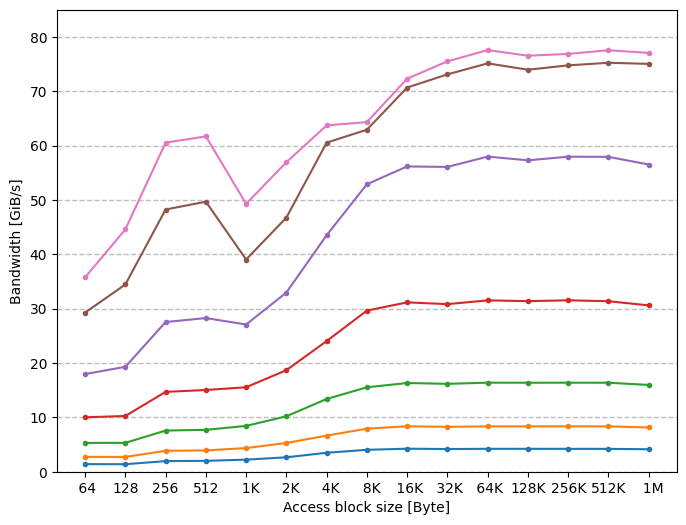

('pegasus', 'devdax', 'read', 'sequential', True)


nthreads,1,2,4,8,16,32,48
blockSize,,,,,,,
64,3.693396,7.206588,13.743321,25.302432,44.652914,63.825217,70.357477
128,3.930329,7.677746,14.813192,27.562544,48.888493,69.072194,74.786831
256,4.162355,8.157287,15.788090,29.833823,54.731162,74.529428,77.349394
512,4.117635,8.070883,15.523008,28.934522,52.935749,73.413539,76.931841
1024,4.133399,8.127319,15.598716,29.051044,53.222521,74.244227,77.503988
2048,3.693046,7.219313,14.005179,26.650508,50.994089,70.789650,76.584481
4096,4.151411,7.806481,15.740884,28.778440,52.812844,73.608108,75.894449
8192,4.467424,8.796471,17.184624,32.619364,59.403127,76.399144,78.938156
16384,4.448746,8.775660,17.138003,32.568755,58.884540,75.304053,77.872658


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


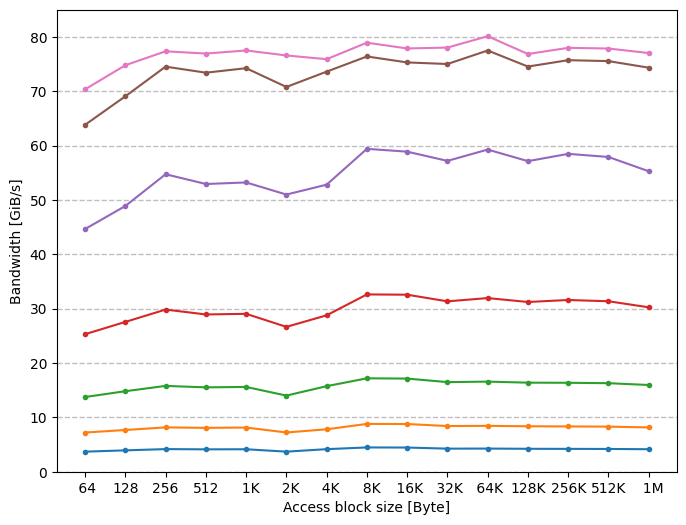

('pegasus', 'devdax', 'write', 'random', False)


nthreads,1,2,4,8,16,32,48
blockSize,,,,,,,
64,0.081519,0.162036,0.321478,0.634226,1.237811,2.370340,3.419241
128,0.156827,0.311669,0.617574,1.215586,2.363432,4.503712,6.468537
256,0.285206,0.566156,1.118816,2.185035,4.160684,7.514666,10.161691
512,0.529341,1.036285,1.999654,3.757607,6.661353,11.048767,13.778065
1024,1.132501,2.195217,4.130772,7.311054,11.527125,14.077830,15.561624
2048,1.558792,2.958341,5.383256,9.269184,13.430530,16.450896,17.084894
4096,2.143852,4.044428,7.203210,11.860156,16.315583,18.631485,18.809841
8192,2.426316,4.540633,8.060471,12.893052,16.839267,18.777428,23.532292
16384,2.558509,4.790424,8.558243,13.245662,17.077854,22.139263,23.588631


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


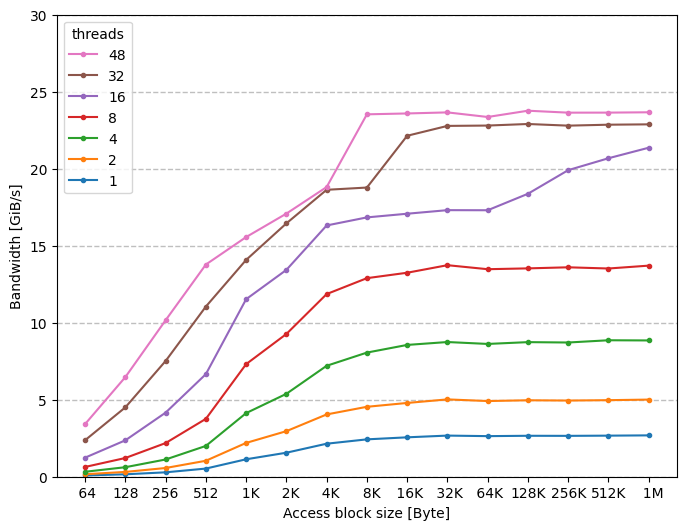

('pegasus', 'devdax', 'write', 'random', True)


nthreads,1,2,4,8,16,32,48
blockSize,,,,,,,
64,0.246226,0.492092,0.982776,1.960056,3.900847,7.701485,11.228971
128,0.485447,0.969819,1.934405,3.849868,7.588177,14.131613,18.749892
256,0.966864,1.928829,3.829884,7.465065,13.522318,20.351495,22.901939
512,1.824290,3.628704,7.087652,12.816872,19.460333,23.483215,24.031662
1024,3.353251,6.602805,12.168817,19.085528,23.726805,24.510162,24.434795
2048,5.715348,10.927116,17.916948,23.523203,24.622272,24.550443,24.420119
4096,8.512770,15.483256,23.521259,24.624411,24.559462,24.425824,24.094111
8192,11.408248,18.931370,24.325274,24.566085,24.443418,23.830849,23.374259
16384,13.692708,21.946636,24.773886,24.667844,24.140168,23.404005,23.219732


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


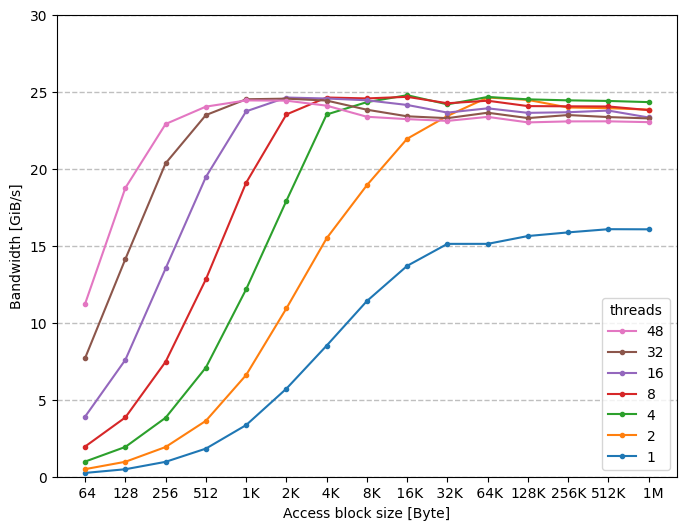

('pegasus', 'devdax', 'write', 'sequential', False)


nthreads,1,2,4,8,16,32,48
blockSize,,,,,,,
64,0.222994,0.445175,0.887578,1.766807,3.503318,6.848895,10.036559
128,0.427475,0.852670,1.691303,3.340355,6.493613,11.749446,15.823705
256,0.787035,1.561329,3.089566,5.825315,10.362316,15.916275,18.299193
512,1.233587,2.368225,4.372477,7.688309,12.407994,16.854894,18.682513
1024,1.757843,3.407862,6.390498,11.073486,16.344601,19.027318,19.210000
2048,1.987526,3.798515,6.949162,11.518120,15.960320,18.846079,19.104618
4096,2.201060,4.160858,7.476563,12.177443,16.619176,19.012397,19.379768
8192,2.424249,4.573239,8.131185,12.988793,16.948456,19.106103,23.534527
16384,2.553779,4.795336,8.467107,13.079477,16.954608,22.097531,23.465968


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


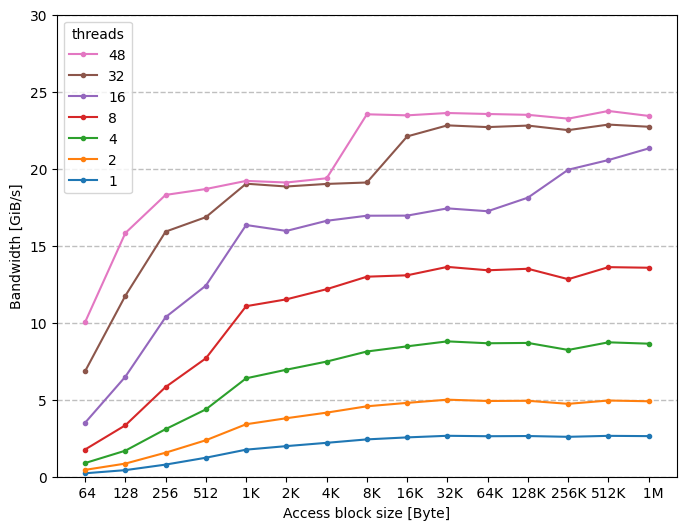

('pegasus', 'devdax', 'write', 'sequential', True)


nthreads,1,2,4,8,16,32,48
blockSize,,,,,,,
64,0.246593,0.492889,0.984695,1.964255,3.909318,7.720526,11.326183
128,0.487091,0.972502,1.939224,3.859236,7.638054,14.620237,20.243575
256,0.966348,1.929547,3.849152,7.660208,14.739505,24.094131,25.216563
512,1.823278,3.639830,7.222755,13.861603,23.142209,25.403784,24.889118
1024,3.351669,6.641580,12.653881,22.279751,25.094968,24.849685,24.534215
2048,5.739403,11.176850,19.982408,24.786091,24.708659,24.575313,24.383440
4096,8.582763,15.954092,24.723927,25.786644,25.177816,24.689140,24.204667
8192,11.507166,19.705706,25.177555,25.565717,25.028022,24.060040,23.471498
16384,13.691720,22.422960,25.335828,25.354389,24.492856,23.549117,23.313881


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


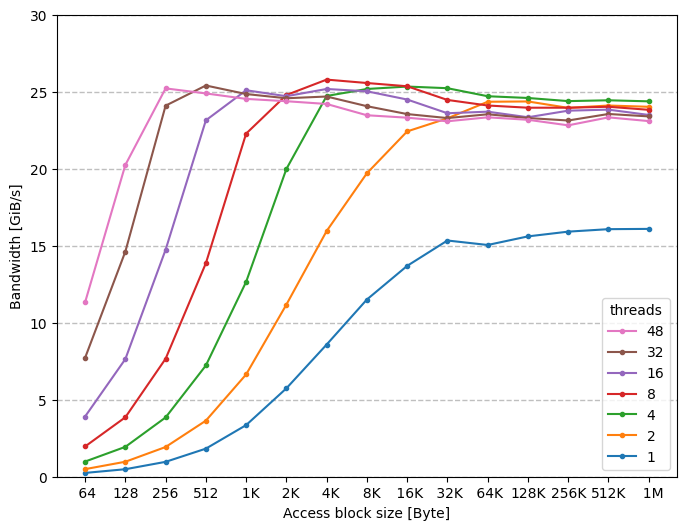

In [40]:
df = grouper.max().reset_index()

ymax = df.groupby(["accessType"]).max()["byte_per_sec"].apply(lambda x: x / 2**30).apply(lambda x: x + -x % 5).astype('int').to_dict()

for idx, df_sub in df.query("platform == 'pegasus' and source == 'devdax'").groupby(["platform", "source", "accessType", "accessPattern", "nonTemporal"]):
    print(idx)
    # display(df_sub)
    df_sub["GiB/s"] = df_sub["byte_per_sec"] / 2**30
    df_plot = df_sub.pivot(index="blockSize", columns="nthreads", values="GiB/s")
    display(df_plot)

    fig = plt.figure(figsize=(8,6), dpi=100)
    fig.patch.set_alpha(1)

    ax = df_plot.plot(
        ax=fig.add_subplot(),
        xlabel="Access block size [Byte]",
        ylabel="Bandwidth [GiB/s]",
        ylim=[0, ymax[idx[2]]],
        style=".-",
        legend=idx[2] == "write",
    )
    if idx[2] == "read":
        store_type = ""
    else:
        if idx[4]:
            store_type = ", nt-store"
        else:
            store_type = ", store and flush"
    # ax.set_title(f"{idx[0].capitalize()}, {idx[1].capitalize()}, {idx[3].capitalize()} {idx[2].capitalize()}{store_type}")
    ax.set_xscale("log", base=2)
    ax.set_xticks(df_plot.index, [pretty_fmt(x, suffix="") for x in df_plot.index])
    ax.grid(which = "major", axis = "y", alpha = 0.8,
        linestyle = "--", linewidth = 1)

    if idx[2] == "write":
        handles, labels = ax.get_legend_handles_labels()# 凡例の情報を取得
        ax.legend(title='threads', handles=handles[::-1],labels=labels[::-1])# 判例を逆順に表示
        # ax.legend(handles=handles[::-1],labels=list(map(lambda x: f"{x} proc{'s' if int(x) > 1 else ''}", labels[::-1])))# 判例を逆順に表示
    
    fig.show()
    save(fig, f"pmembench-{idx[0]}-{idx[1]}-{idx[2]}-{idx[3]}{'-movnt' if idx[2] == 'write' and idx[4] else ''}")
    plt.show()



In [29]:
df = df_src
df

,accessPattern,accessType,blockSize,granularity,nonTemporal,nthreads,path,set-affinity,source,stripeSize,...,iter,platform,device,IOPS,MIOPS,MiB_per_sec,addr,byte_per_sec,success,time
0,random,write,2048,page,True,8,/dev/dax0.0,True,anon,68719476736,...,3,pegasus,Optane 300,2.937056e+06,2.937056,5736.438243,22866405883904,6.015091e+09,True,11424.510684
1,sequential,read,128,page,True,4,/dev/dax0.0,True,anon,34359738368,...,2,pegasus,Optane 300,5.278782e+07,52.787820,6443.825730,22772990345216,6.756841e+09,True,5085.177870
2,sequential,write,65536,page,False,8,/dev/dax0.0,True,anon,68719476736,...,3,pegasus,Optane 300,1.061356e+05,0.106136,6633.476826,22926535426048,6.955705e+09,True,9879.585279
3,sequential,write,16384,page,False,1,/dev/dax0.0,True,anon,8589934592,...,3,pegasus,Optane 300,1.817156e+05,0.181716,2839.305942,22934051618816,2.977228e+09,True,2885.212149
4,random,read,2048,page,True,1,/dev/dax0.0,True,devdax,8589934592,...,2,pegasus,Optane 300,1.390240e+06,1.390240,2715.312697,21205327282176,2.847212e+09,True,3016.963759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8059,sequential,write,4096,page,True,16,/dev/dax0.0,True,devdax,137438953472,...,1,chris90,Optane 200,2.313566e+06,2.313566,9037.368564,139701327495168,9.476368e+09,True,14503.336793
8060,random,write,262144,page,False,2,/dev/dax0.0,True,devdax,17179869184,...,2,chris90,Optane 200,2.796750e+04,0.027968,6991.876170,139362025078784,7.331514e+09,True,2343.290928
8061,sequential,read,2048,page,True,4,/dev/dax0.0,True,devdax,34359738368,...,3,chris90,Optane 200,7.490629e+06,7.490629,14630.134273,139271830765568,1.534081e+10,True,2239.760715
8062,random,write,512,page,False,8,/dev/dax0.0,True,devdax,68719476736,...,1,chris90,Optane 200,9.620860e+06,9.620860,4697.685482,139626165567488,4.925880e+09,True,13950.699819


In [30]:
# pegasus upto 16 threads
df = df_src.query("platform == 'pegasus' and nthreads<=16").drop(["path", "granularity", "set-affinity", "addr", "success"], axis=1)

max_throuput_groupby = ["platform", "source", "accessType", "accessPattern", "nonTemporal", "blockSize"]
pegasus16_grouper = df.groupby(max_throuput_groupby)
df_pegasus16_max = df.loc[pegasus16_grouper["byte_per_sec"].idxmax()]

df_pegasus16_max.platform = "pegasus16"

df_pegasus16_max.query("accessType == 'write' and blockSize==64")


,accessPattern,accessType,blockSize,nonTemporal,nthreads,source,stripeSize,totalSize,iter,platform,device,IOPS,MIOPS,MiB_per_sec,byte_per_sec,time
2140,random,write,64,False,8,anon,68719476736,68719476736,2,pegasus16,Optane 300,8.752398e+07,87.523983,5342.039993,5.601535e+09,12267.972552
2085,random,write,64,True,8,anon,68719476736,68719476736,3,pegasus16,Optane 300,4.373886e+07,43.738865,2669.608456,2.799287e+09,24548.918347
1723,sequential,write,64,False,8,anon,68719476736,68719476736,2,pegasus16,Optane 300,1.153510e+08,115.350952,7040.463368,7.382461e+09,9308.478232
2538,sequential,write,64,True,8,anon,68719476736,68719476736,3,pegasus16,Optane 300,3.383153e+07,33.831528,2064.912620,2.165218e+09,31737.904718
1047,random,write,64,False,16,devdax,137438953472,137438953472,3,pegasus16,Optane 300,2.076702e+07,20.767020,1267.518284,1.329089e+09,103408.370265
3067,random,write,64,True,16,devdax,137438953472,137438953472,3,pegasus16,Optane 300,6.544535e+07,65.445349,3994.467093,4.188502e+09,32813.388356
403,sequential,write,64,False,16,devdax,137438953472,137438953472,1,pegasus16,Optane 300,5.877592e+07,58.775925,3587.397751,3.761659e+09,36536.790485
2974,sequential,write,64,True,16,devdax,137438953472,137438953472,1,pegasus16,Optane 300,6.558747e+07,65.587471,4003.141514,4.197598e+09,32742.284914
4405,random,write,64,False,16,fsdax,137438953472,137438953472,3,pegasus16,Optane 300,2.076186e+07,20.761857,1267.203216,1.328759e+09,103434.080932
4155,random,write,64,True,16,fsdax,137438953472,137438953472,2,pegasus16,Optane 300,6.545542e+07,65.455424,3995.082040,4.189147e+09,32808.337524


In [31]:
df = df_src.query("success == True").drop(["path", "granularity", "set-affinity", "addr", "success"], axis=1)

# max throuput
max_throuput_grouper = df.groupby(max_throuput_groupby)

pd.set_option('display.max_rows', 50)
df_max = df.loc[max_throuput_grouper["byte_per_sec"].idxmax()]

# df_max = pd.concat([df_max, df_pegasus16_max])

df_max = df_max.query("source == 'devdax' and nonTemporal == True")

df_max["GiB/s"] = df_max["byte_per_sec"] / 2**30
df_max

,accessPattern,accessType,blockSize,nonTemporal,nthreads,source,stripeSize,totalSize,iter,platform,device,IOPS,MIOPS,MiB_per_sec,byte_per_sec,time,GiB/s
7122,random,read,64,True,16,devdax,137438953472,137438953472,1,chris90,Optane 200,1.844989e+08,184.498887,11260.918376,1.180793e+10,11639.548003,10.996991
7343,random,read,128,True,16,devdax,137438953472,137438953472,1,chris90,Optane 200,1.152865e+08,115.286522,14073.061755,1.475667e+10,9313.680440,13.743224
7672,random,read,256,True,16,devdax,137438953472,137438953472,2,chris90,Optane 200,1.050482e+08,105.048232,25646.541054,2.689235e+10,5110.708681,25.045450
7324,random,read,512,True,16,devdax,137438953472,137438953472,3,chris90,Optane 200,3.803259e+07,38.032585,18570.598224,1.947268e+10,7058.038649,18.135350
6985,random,read,1024,True,16,devdax,137438953472,137438953472,2,chris90,Optane 200,2.170663e+07,21.706634,21197.884657,2.222759e+10,6183.258477,20.701059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3173,sequential,write,65536,True,4,devdax,34359738368,34359738368,2,pegasus,Optane 300,4.048022e+05,0.404802,25300.140579,2.652912e+10,1295.170669,24.707169
2585,sequential,write,131072,True,4,devdax,34359738368,34359738368,2,pegasus,Optane 300,2.014744e+05,0.201474,25184.295563,2.640765e+10,1301.128313,24.594039
1020,sequential,write,262144,True,4,devdax,34359738368,34359738368,3,pegasus,Optane 300,9.990292e+04,0.099903,24975.730142,2.618895e+10,1311.993676,24.390361
3107,sequential,write,524288,True,4,devdax,34359738368,34359738368,2,pegasus,Optane 300,5.006100e+04,0.050061,25030.502468,2.624638e+10,1309.122741,24.443850


{'read': 90, 'write': 30}


,Optane 200 random,Optane 200 sequential,Optane 300 random,Optane 300 sequential
blockSize,,,,
64,10.996991,27.877246,35.759426,70.357477
128,13.743224,29.762812,44.581031,74.786831
256,25.045450,35.935714,60.542520,77.349394
512,18.135350,36.436450,61.697388,76.931841
1024,20.701059,35.406989,49.283609,77.503988
2048,21.583009,34.009234,56.942540,76.584481
4096,28.260335,35.024448,63.720457,75.894449
8192,32.672510,44.671387,64.327501,78.938156
16384,35.632235,45.740933,72.312425,77.872658


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


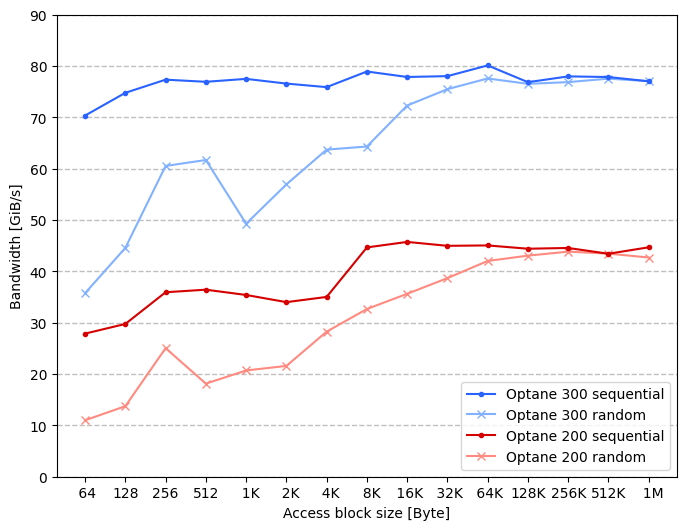

,Optane 200 random,Optane 200 sequential,Optane 300 random,Optane 300 sequential
blockSize,,,,
64,3.821872,9.815379,11.228971,11.326183
128,7.445287,14.722460,18.749892,20.243575
256,14.011531,14.986178,22.901939,25.216563
512,13.437177,13.892558,24.031662,25.403784
1024,12.443069,13.173816,24.510162,25.094968
2048,11.473061,12.231334,24.622272,24.786091
4096,9.819301,11.248943,24.624411,25.786644
8192,10.159971,11.261540,24.566085,25.565717
16384,11.198028,11.988921,24.773886,25.354389


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


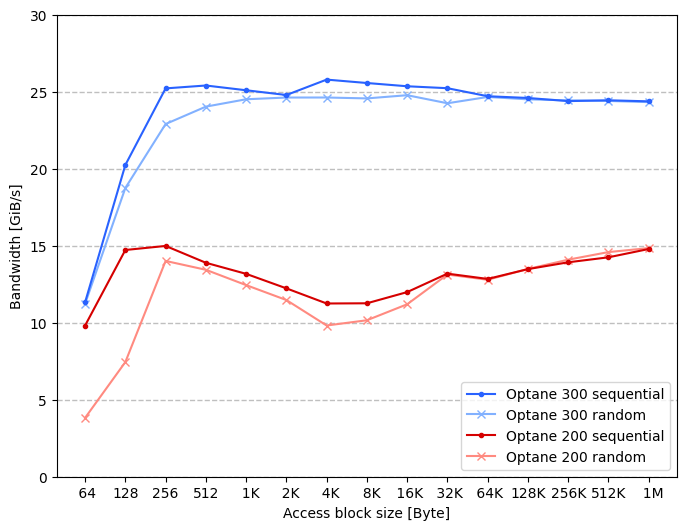

In [32]:
# for idx, df_sub in df_max.groupby(["platform", "source", "accessPattern", "accessType", "nonTemporal"]):
    # display(idx)
    # df_pivot = df_sub.set_index("blockSize")["GiB/s"].rename(f"{idx[0].capitalize()}-{idx[1].upper()}-{idx[2]}-{idx[3]}{'-MOVNT' if idx[3] == 'write' and idx[4] else ''}")
    # display(df_pivot)

df = df_max

ymax = df.groupby(["accessType"]).max()["byte_per_sec"].apply(lambda x: x / 2**30).apply(lambda x: x + -x % 5).astype('int').to_dict()
ymax["read"] = 90
print(ymax)

platform_list = ["chris90", "pegasus"]
# blocksize_list = [64, 256, 4*1024, 128*1024]
blocksize_list = [2**x for x in range(6, 21)]

df = df.loc[df.blockSize.isin(blocksize_list)]

color_list = [
    "#ff8a80", 
    "#d50000",
    "#82b1ff",
    "#2962ff",
]

for accessType in ["read", "write"]:
    df_plot = pd.concat([
        df_sub.set_index("blockSize")["GiB/s"].rename(f"{idx[3]} {idx[1]}")
        for platform in platform_list
        for idx, df_sub in df[(df.accessType == accessType) & (df.platform == platform)].groupby(["source", "accessPattern", "nonTemporal", "device"])
    ], axis=1)

    # df_plot.index = df_plot.index.map(lambda x: pretty_fmt(x, suffix=""))

    display(df_plot)

    fig = plt.figure(figsize=(8, 6), dpi=100)
    fig.patch.set_alpha(1)

    ax = df_plot.plot(
        # kind="bar",
        ax=fig.add_subplot(),
        rot=0,
        xlabel="Access block size [Byte]",
        ylabel="Bandwidth [GiB/s]",
        ylim=[0, ymax[accessType]],
        style=["x-", ".-", "x-", ".-"],
        color=color_list,
    )
    
    # ax.set_title(f"Devdax {accessType.capitalize()} {'( nt-store )' if accessType == 'write' else ''}")
    ax.set_xscale("log", base=2)
    ax.set_xticks(df_plot.index, [pretty_fmt(x, suffix="") for x in df_plot.index])
    ax.grid(which = "major", axis = "y", alpha = 0.8, linestyle = "--", linewidth = 1)

    handles, labels = ax.get_legend_handles_labels()# 凡例の情報を取得
    ax.legend(handles=handles[::-1],labels=labels[::-1])# 判例を逆順に表示

    fig.show()
    save(fig, f"pmembench-comp-devdax-{accessType}")
    plt.show()